In [111]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [112]:
GOLD_DATA_PATH = "/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/data/all_data.csv"
csv_dataset = pd.read_csv(GOLD_DATA_PATH, index_col=0)
model_name = "meta-llama/Llama-3.1-8B-Instruct"
model_name = "google/gemma-2-9b-it"
# model_name = "mistralai/Mistral-Nemo-Instruct-2407"

In [113]:
def pred_role_type_func(LLM_responses: json) -> tuple[list, list]:
    role_preds = []
    type_preds = []
    func_preds = []

    for each_response in LLM_responses:
        # print(each_response[-1]['generated_text'])
        completion = each_response[-1]['generated_text'][-1]
        if completion['role'] == 'assistant':
            try:
                role_preds.append(completion['content'].split("ROLE: ")[1].split()[0])
                # print(role_preds)
            except:
                role_preds.append("FormatError")
            try:
                # print("TYPE:", completion['content'].split("TYPE: ")[1].split()[0])
                type_preds.append(completion['content'].split("TYPE: ")[1].split()[0])
            except:
                # print("format error")
                type_preds.append("FormatError")
            try:
                # print("FUNCTION:", completion['content'].split("FUNCTION: ")[1].split()[0])
                func_preds.append(completion['content'].split("FUNCTION: ")[1].split()[0])
            except:
                # print("format error")
                func_preds.append("FormatError")

    return role_preds, type_preds, func_preds

In [114]:
def evaluation_metrics(gold:list[str], pred:list[str], eval_mode:str) -> dict:
    if eval_mode == "role":
        label_set = ["Method", "Material", "Supplement", "Mixed"]
    elif eval_mode == "type":
        label_set = ["Tool", "Code", "Dataset", "Knowledge", "DataSource", "Document", "Paper", "Media", "Website", "Mixed"]
    elif eval_mode == "func":
        label_set = ["Use", "Produce", "Compare", "Extend", "Introduce", "Other"]
    else:
        print("set apprepriate eval_mode")

    acc = accuracy_score(gold, pred)
    pre = precision_score(gold, pred, labels=label_set, average="macro", zero_division=0)
    rec = recall_score(gold, pred, average="macro", zero_division=0)
    if pre * rec == 0:
        f1 = 0
    else:
        f1 = 2 * pre * rec / (pre + rec)
    err_rate = pred.count('FormatError') / len(pred)

    return {"acc": acc, "pre":pre, "rec":rec, "f1":f1, "err": err_rate}

In [115]:
def ave_metrics_seed(metrics_lst:list[dict]) -> dict:
    """
    Parameters:
        dict_list (list): 

    Returns:
        dict: 
    """
    if not metrics_lst:
        return {}

    # 初期化
    result = {}
    num_dicts = len(metrics_lst)

    # キーごとに値を合計
    for d in metrics_lst:
        for key, value in d.items():
            result[key] = result.get(key, 0) + value

    # 平均を計算
    for key in result:
        result[key] /= num_dicts

    return result

In [116]:
def round_print(input_dict:dict, round_num:int=3):
    rounded_data = {key: round(value, round_num) for key, value in input_dict.items()}
    return rounded_data

In [117]:
show_roles = []
show_types = []
show_funcs = []

In [118]:
for icl_method in ["random", "bm25", "encoder"]:
    print(f"icl_method = {icl_method}")
    for k in range(1, 5+1):
        print(f"{str(k)}-shot")
        metrics_roles_seeds = []
        metrics_types_seeds = []
        metrics_funcs_seeds = []
        for seed in [111, 5374, 93279]:
            # print(seed)
            # create gold answer
            train_df, eval_df = train_test_split(csv_dataset, test_size = 0.1, random_state=int(seed))
            gold_roles, gold_types, gold_funcs = [], [], []
            for i, row in eval_df.iterrows():
                gold_roles.append(row['role'].replace('補足資料', 'Supplement'))
                gold_types.append(row['type'])
                gold_funcs.append(row['function'].split("（")[0])
            # print(gold_roles)

            # create pred answer
            pred_data_path = f"/data/group1/z40436a/ME/URL_Citation_Classification_Intermediate/result/output/{model_name}/{icl_method}/{str(seed)}_{str(k)}shot.json"
            with open(pred_data_path, 'r') as json_file:
                LLM_responses = json.load(json_file)

            pred_roles, pred_types, pred_funcs = pred_role_type_func(LLM_responses)

            pred_roles = [pred if pred in list(set(gold_roles)) else "FormatError" for pred in pred_roles]
            pred_types = [pred if pred in list(set(gold_types)) else "FormatError" for pred in pred_types]
            pred_funcs = [pred if pred in list(set(gold_funcs)) else "FormatError" for pred in pred_funcs]

            # print(pred_roles)

            metrics_roles_seeds.append(evaluation_metrics(gold_roles, pred_roles, "role"))
            metrics_types_seeds.append(evaluation_metrics(gold_types, pred_types, "type"))
            metrics_funcs_seeds.append(evaluation_metrics(gold_funcs, pred_funcs, "func"))

        print("ROLE:", end="")
        round_role = round_print(ave_metrics_seed(metrics_roles_seeds))
        print(f"f1: {round_role['f1']}, err: {round_role['err']}")
        show_roles.append(ave_metrics_seed(metrics_roles_seeds))
        print("TYPE:", end="")
        round_type = round_print(ave_metrics_seed(metrics_types_seeds))
        print(f"f1: {round_type['f1']}, err: {round_type['err']}")
        show_types.append(ave_metrics_seed(metrics_types_seeds))
        print("FUNC:", end="")
        round_func = round_print(ave_metrics_seed(metrics_funcs_seeds))
        print(f"f1: {round_func['f1']}, err: {round_func['err']}")
        show_funcs.append(ave_metrics_seed(metrics_funcs_seeds))

icl_method = random
1-shot
ROLE:f1: 0.001, err: 0.998
TYPE:f1: 0.014, err: 0.988
FUNC:f1: 0.0, err: 1.0
2-shot
ROLE:f1: 0.467, err: 0.146
TYPE:f1: 0.413, err: 0.047
FUNC:f1: 0.406, err: 0.048
3-shot
ROLE:f1: 0.466, err: 0.09
TYPE:f1: 0.479, err: 0.001
FUNC:f1: 0.498, err: 0.007
4-shot
ROLE:f1: 0.502, err: 0.099
TYPE:f1: 0.463, err: 0.004
FUNC:f1: 0.506, err: 0.009
5-shot
ROLE:f1: 0.485, err: 0.107
TYPE:f1: 0.435, err: 0.006
FUNC:f1: 0.518, err: 0.011
icl_method = bm25
1-shot
ROLE:f1: 0.039, err: 0.968
TYPE:f1: 0.054, err: 0.945
FUNC:f1: 0.029, err: 0.983
2-shot
ROLE:f1: 0.535, err: 0.225
TYPE:f1: 0.452, err: 0.156
FUNC:f1: 0.426, err: 0.161
3-shot
ROLE:f1: 0.607, err: 0.059
TYPE:f1: 0.538, err: 0.002
FUNC:f1: 0.591, err: 0.003
4-shot
ROLE:f1: 0.602, err: 0.067
TYPE:f1: 0.526, err: 0.004
FUNC:f1: 0.586, err: 0.004
5-shot
ROLE:f1: 0.614, err: 0.042
TYPE:f1: 0.532, err: 0.002
FUNC:f1: 0.6, err: 0.004
icl_method = encoder
1-shot
ROLE:f1: 0.037, err: 0.971
TYPE:f1: 0.051, err: 0.961
FUNC:f1

In [119]:
print(show_roles[-2:])

[{'acc': 0.7023411371237458, 'pre': 0.761445828909916, 'rec': 0.4877884012846981, 'f1': 0.5941618915622427, 'err': 0.043478260869565216}, {'acc': 0.7123745819397994, 'pre': 0.766801183834775, 'rec': 0.4946519973029709, 'f1': 0.6009539968089093, 'err': 0.03567447045707916}]


In [120]:
print(list(set(gold_types)))

['Dataset', 'Paper', 'Code', 'Document', 'Website', 'Media', 'Mixed', 'Knowledge', 'Tool', 'DataSource']


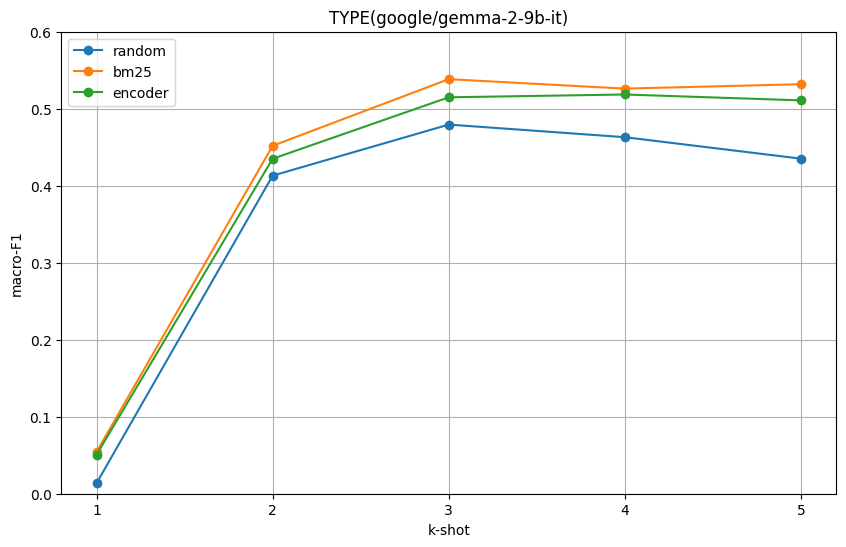

In [121]:
import matplotlib.pyplot as plt

# データをロード
data = show_types

# f1スコアを取得
f1_scores = [entry['f1'] for entry in data]

# 5個ずつに分割
chunk_size = 5
chunks = [f1_scores[i:i + chunk_size] for i in range(0, len(f1_scores), chunk_size)]

# 図示
plt.figure(figsize=(10, 6))
icl_methods = ["random", "bm25", "encoder"]
for i, chunk in enumerate(chunks):
    plt.plot(chunk, label=icl_methods[i], marker='o')

# グラフの装飾
plt.title(f"TYPE({model_name})")
plt.xlabel("k-shot")
plt.xticks(range(5), range(1, 6))
plt.ylabel("macro-F1")
plt.ylim(0.0, 0.60)
plt.legend()
plt.grid()
plt.show()

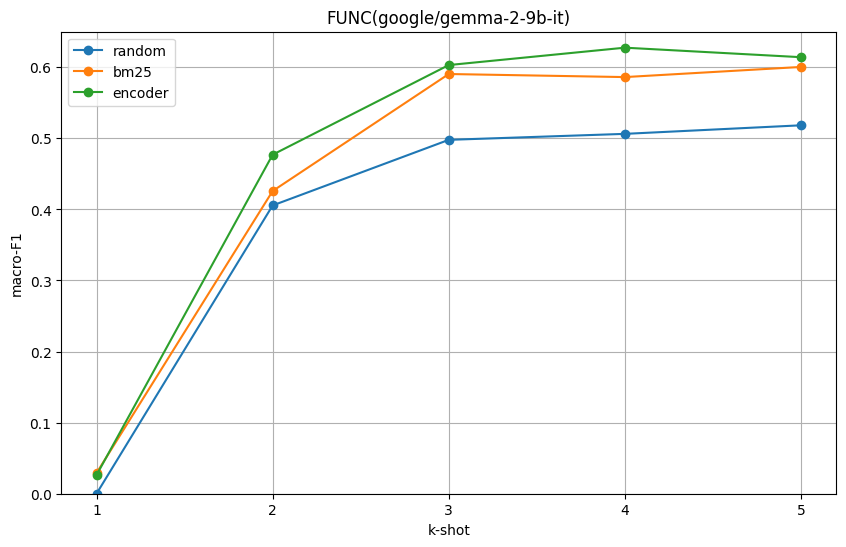

In [122]:
import matplotlib.pyplot as plt

# データをロード
data = show_funcs

# f1スコアを取得
f1_scores = [entry['f1'] for entry in data]

# 5個ずつに分割
chunk_size = 5
chunks = [f1_scores[i:i + chunk_size] for i in range(0, len(f1_scores), chunk_size)]

# 図示
plt.figure(figsize=(10, 6))
icl_methods = ["random", "bm25", "encoder"]
for i, chunk in enumerate(chunks):
    plt.plot(chunk, label=icl_methods[i], marker='o')

# グラフの装飾
plt.title(f"FUNC({model_name})")
plt.xlabel("k-shot")
plt.xticks(range(5), range(1, 6))
plt.ylabel("macro-F1")
plt.ylim(0.0, 0.65)
plt.legend()
plt.grid()
plt.show()